# DPCM Card Game Simulator

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import ast

### Variables

In [2]:
purple = '#7f00ff'
orange = '#ff4500'

### Analysis

In [ ]:
results_df = pd.read_csv('../data/results.csv')

In [ ]:
fig = plt.figure(1, figsize=(15, 7))

n, bins, patches = plt.hist(results_df['Turns'], bins=np.arange(0, max(results_df['Turns']), 5), color=purple, edgecolor='w')

x = range(max(results_df['Turns']))
plt.xticks(np.arange(min(x), max(x)+10, 5))

n = list(n)
patches[n.index(max(n))].set_fc(orange)

plt.xlabel('Turns per Game')
plt.ylabel('Number of games')

plt.title('Turns Distribution')

plt.show()

In [ ]:
fig = plt.figure(1, figsize=(15, 7))

not_fair_file = 'not_fair.csv'
fair_file = 'fair.csv'

not_fair_df = pd.read_csv('../data/' + not_fair_file)
fair_df = pd.read_csv('../data/' + fair_file)

plt.plot(not_fair_df.index, not_fair_df['Rate'], color = orange, label='Win-Rate not fair')
plt.plot(fair_df.index, fair_df['Rate'], color = purple, label='Win-Rate fair')

plt.hlines(0.5, 0, len(not_fair_df), colors='black', linestyles='dashed')

plt.title('Win Rate with Starting Advantage')

plt.legend(loc='lower right')

plt.xlabel('Simulations')
plt.ylabel('Win Rate')

plt.show()

In [ ]:
print(f'{abs(not_fair_df['Rate'].iloc[-1] - fair_df['Rate'].iloc[-1])*100:.2f}%')

### Human VS AI

In [ ]:
fig = plt.figure(1, figsize=(15, 7))

fair_file = 'fair.csv'
fair_df = pd.read_csv('../data/' + fair_file)

plt.plot(results_df.index, results_df['Rate'], color = orange, label='AI')
plt.plot(fair_df.index, fair_df['Rate'], color = purple, label='Human')

plt.hlines(0.5, 0, len(not_fair_df), colors='black', linestyles='dashed')

plt.title('Win Rate with Starting Advantage')

plt.legend(loc='lower right')

plt.xlabel('Simulations')
plt.ylabel('Win Rate')

plt.show()

In [ ]:
print(f'{abs(results_df['Rate'].iloc[-1] - fair_df['Rate'].iloc[-1])*100:.2f}%')

### Visits

In [ ]:
visited_df = pd.read_csv('../data/visited.csv')

In [ ]:
visited_df['MAX'] = visited_df.iloc[:, 1:].max(axis=1)
visited_df['HAND'] = visited_df['ID'].apply(lambda x: sum(eval(x)[3:]))

In [ ]:
visited_pivot = visited_df.drop(columns='MAX').iloc[:, 1:].groupby('HAND').sum()
visited_pivot = visited_pivot.replace(0, np.NaN)

fig, ax = plt.subplots(1, 1, figsize = (15, 12))

cmap_custom = LinearSegmentedColormap.from_list('custom', [purple, orange])

sns.heatmap(visited_pivot, 
            fmt='.0f', 
            linewidth = 0.3, 
            annot = True,
            cbar = True,
            cmap=cmap_custom,
            square=True)

ax.title.set_text('Visits')

ax.set(xlabel='Move taken', ylabel='Hand Cards Playable')

plt.show()

### Exploration

In [ ]:
visits_df = pd.read_csv('../data/visits.csv')

In [ ]:
visits_df.head()

In [ ]:
visits_df['Cumsum'] = visits_df['Visits'].cumsum()

In [ ]:
visits_df.head()

In [ ]:
fig = plt.figure(1, figsize=(10, 10))

x = np.linspace(0, max(visits_df.index))
y = x

plt.plot(visits_df.index, visits_df['Cumsum'], color = orange, label='Coverage')
plt.plot(x, y, color = 'black', label='Linear', linestyle='--')

plt.title('State/Move Coverage')

plt.legend(loc='lower right')

plt.xlabel('Turns of games')
plt.ylabel('State/Move Pairs Visited')

plt.show()

### Cards Playable

In [ ]:
visited_df = pd.read_csv('../data/visited.csv')

In [ ]:
visited_df.head()

In [ ]:
visited_df['VISITS'] = visited_df.iloc[:, 1:].max(axis=1)

In [ ]:
visited_filtered_df = visited_df[visited_df['VISITS'] > 0]

In [ ]:
visited_filtered_df.reset_index(drop=True, inplace=True)

In [ ]:
visited_filtered_df.head()

In [ ]:
print(len(visited_df), len(visited_filtered_df), str(round(len(visited_filtered_df)*100/len(visited_df), 2)) + '%')

In [ ]:
state_max_df = visited_filtered_df[['ID', 'VISITS']].copy()

In [ ]:
state_max_df.head()

In [ ]:
state_max_df['ID'] = state_max_df['ID'].apply(ast.literal_eval)

In [ ]:
state_max_df.head()

In [ ]:
state_max_df['HAND'] = state_max_df['ID'].apply(lambda x: x[3:])

In [ ]:
state_max_df.head()

In [ ]:
state_max_df['HAND'] = state_max_df['HAND'].apply(lambda x: sum(x))

In [ ]:
state_max_df.head()

In [ ]:
state_max_df = state_max_df.drop('ID', axis=1)

In [ ]:
state_max_df.head()

In [ ]:
state_max_df = pd.DataFrame(state_max_df.groupby('HAND')['VISITS'].sum())

In [ ]:
state_max_df.reset_index(drop=False, inplace=True)

In [ ]:
state_max_df.head()

In [ ]:
state_max_df['PERCENTAGE'] = round((state_max_df['VISITS'] / state_max_df['VISITS'].sum())*100, 2)

In [ ]:
state_max_df.head()

In [ ]:
state_max_df = state_max_df.drop('VISITS', axis=1)

In [ ]:
state_max_df.head()

In [ ]:
fig = plt.figure(1, figsize=(15, 7))

barra_piu_alta = state_max_df.loc[state_max_df['PERCENTAGE'].idxmax()]

plt.bar(state_max_df['HAND'], state_max_df['PERCENTAGE'], color=purple, edgecolor='w')
plt.bar(barra_piu_alta['HAND'], barra_piu_alta['PERCENTAGE'], color=orange)

plt.xticks(state_max_df['HAND'])

plt.xlabel('Cards in hand')
plt.ylabel('Occurences %')

plt.title('Quantity of playable Cards')

plt.show()

#### Q-Values

In [ ]:
q_df = pd.read_csv('../data/q.csv')

In [ ]:
q_df['MAX'] = q_df.iloc[:, 1:].max(axis=1)

In [ ]:
q_df['HAND'] = q_df['ID'].apply(lambda x: sum(eval(x)[3:]))

In [ ]:
q_curve = q_df.copy()

In [ ]:
q_curve[['HAND', 'MAX']] = q_curve[['HAND', 'MAX']].replace(0, np.NaN)

q_mean = pd.Series(q_curve.iloc[:, 1:].groupby('HAND').mean()['MAX'])
q_max  = pd.Series(q_curve.iloc[:, 1:].groupby('HAND').max()['MAX'])
q_std  = pd.Series(q_curve.iloc[:, 1:].groupby('HAND').std()['MAX']) / 2

In [ ]:
fig = plt.figure(1, figsize=(15,7))

plt.plot(q_mean.index, q_mean, label='Mean', marker='o', color=purple)
plt.plot(q_max.index,  q_max,  label='Max',  marker='o', color=orange)

plt.fill_between(q_mean.index, q_mean - q_std, q_mean + q_std, alpha=1/5, color=purple, edgecolor=None)

plt.xticks(q_mean.index)

plt.xlabel('Number of Minimum Hand Cards')
plt.ylabel('Q-Value')

plt.title('Aggregated Q-Values')

plt.legend()

plt.show()

In [ ]:
q_pivot = q_df.replace(0, np.NaN)
q_pivot = q_pivot.drop(columns='MAX').iloc[:, 1:].groupby('HAND').mean()

fig, ax = plt.subplots(1, 1, figsize = (15, 12))

cmap_custom = LinearSegmentedColormap.from_list('custom', [purple, orange])

sns.heatmap(q_pivot, 
            fmt='.2f', 
            linewidth = 0.3, 
            annot = True,
            cbar = True,
            cmap=cmap_custom,
            square=True)

ax.title.set_text('Visits')

ax.set(xlabel='Move taken', ylabel='Hand Cards Playable')

plt.show()

### Strategy

In [3]:
def get_df_range(df, min, max):
    return df.iloc[min:max, :]

In [4]:
def before_after_filter(riga):
    for i in range(len(riga['Before'])):
        if riga['Before'][i] >= riga['After'][i]:
            continue
        else:
            return False
    return True

In [5]:
def before_certifications_filter(riga):
    for i in range(5, 8):
        if riga['Before'][i] == 1:
            continue
        else:
            return False
    return True

In [6]:
def find_differences(before, after):
    return [i for i, (card1, card2) in enumerate(zip(before, after)) if card1 != card2]

In [7]:
def plot_strategy_heatmap(df):
    heatmap_data = df.pivot(index='CERTIFICATION', columns='ZONE', values='Percentage')

    zones_order = ['WHITE', 'YELLOW', 'ORANGE', 'RED']
    certifications_order = ['RED', 'ORANGE', 'YELLOW']

    heatmap_data = heatmap_data.loc[certifications_order, zones_order]

    fig, ax = plt.subplots(1, 1, figsize = (10, 6))

    sns.heatmap(heatmap_data,
                linewidth = 5,
                annot=True,
                vmin=0,
                vmax=1,
                cmap='rocket_r',
                cbar = True,
                fmt='.0%',
                square=True)

    plt.show()

In [8]:
def get_strategy_heatmap(df, min, max):
    df = get_df_range(df, min, max)

    df.loc[:, 'Before'] = df['Before'].apply(ast.literal_eval)
    df.loc[:, 'After'] = df['After'].apply(ast.literal_eval)

    df.loc[:, 'Before'] = df['Before'].apply(lambda x: x[3:11])
    df.loc[:, 'After'] = df['After'].apply(lambda x: x[3:11])

    df = df[df['Before'] != df['After']]

    df = df[df.apply(before_after_filter, axis=1)]

    df = df[df.apply(before_certifications_filter, axis=1)]

    df['Differences'] = df.apply(lambda row: find_differences(row['Before'], row['After']), axis=1)

    df = df[(df['Differences'].apply(len) > 1) & (df['Differences'].apply(len) < 3)]

    df.loc[:, 'Differences'] = df['Differences'].apply(tuple)

    df = pd.concat([df, df.iloc[[0]]], ignore_index=True)

    df = pd.DataFrame(df.groupby('Differences').size()).reset_index(drop=False)

    df.columns = ['Differences', 'Count']

    df[['ZONE', 'CERTIFICATION']] = df['Differences'].apply(lambda x: pd.Series([x[0], x[1]]))

    df.drop(columns=['Differences'], inplace=True)

    df = df[df['ZONE'] < 4]
    df = df[df['CERTIFICATION'] > 4]

    state_seen_group = df.groupby('ZONE')['Count'].transform('sum')

    df['Percentage'] = df['Count'] / state_seen_group

    df.drop(columns=['Count'], inplace=True)

    zones = {0: 'WHITE', 1: 'YELLOW', 2: 'ORANGE', 3: 'RED'}
    certifications = {5: 'YELLOW', 6: 'ORANGE', 7: 'RED'}

    df['ZONE'] = df['ZONE'].replace(zones)
    df['CERTIFICATION'] = df['CERTIFICATION'].replace(certifications)

    df.reset_index(drop=True, inplace=True)

    print(len(df))

    plot_strategy_heatmap(df)
    
    return df

In [9]:
def generate_tuples(max, interval):
    tuple_list = []
    for i in range(0, max, interval):
        tuple_list.append((i, min(i + interval, max)))
    return tuple_list

42108
9


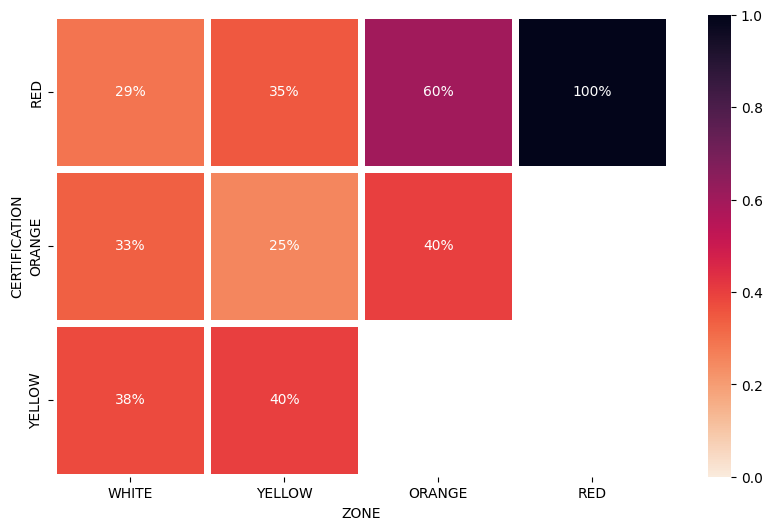

9


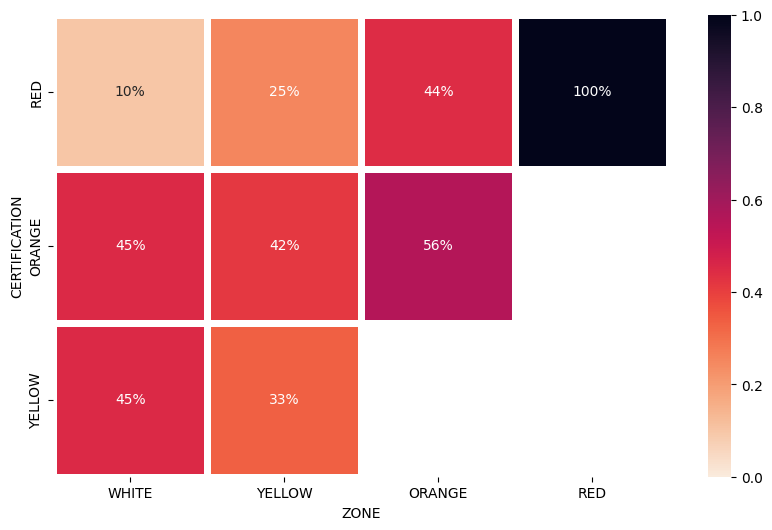

9


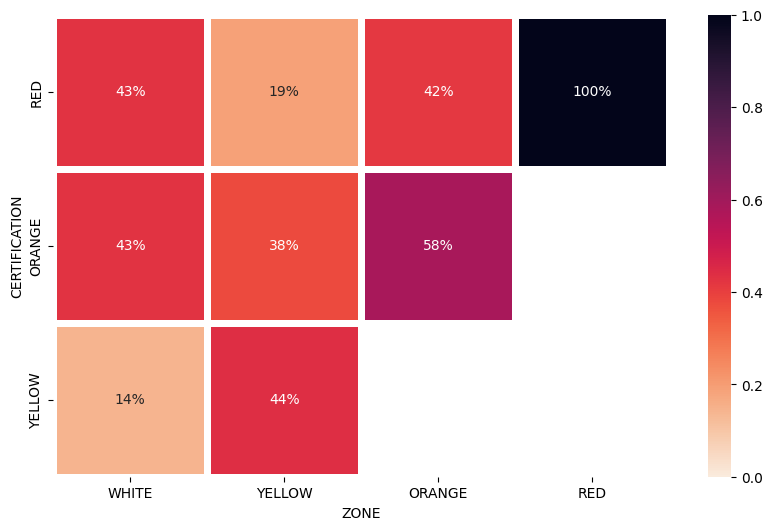

9


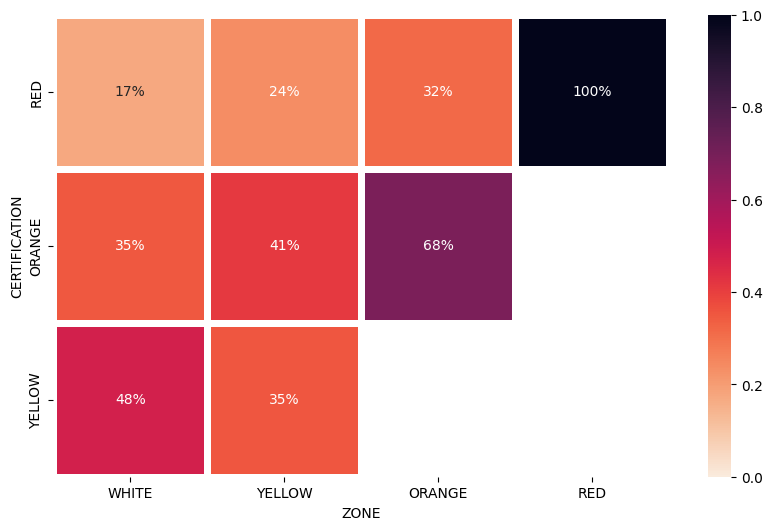

9


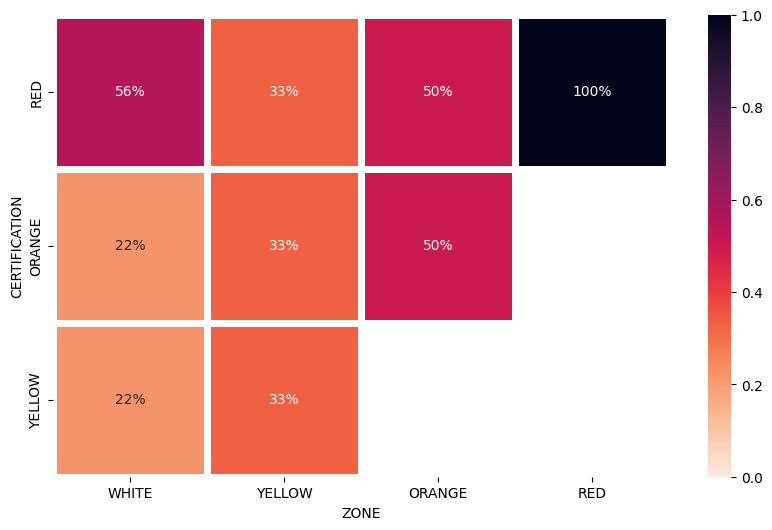

In [10]:
state_seen_df = pd.read_csv('../data/state_seen.csv')

print(len(state_seen_df))

tuple_list = generate_tuples(len(state_seen_df), 10000)
for min_max in tuple_list:
    df = get_strategy_heatmap(state_seen_df, min_max[0], min_max[1])

In [11]:
from moviepy.editor import ImageSequenceClip

image_files = ['../img/strategy-heatmap-0.png', '../img/strategy-heatmap-1.png', '../img/strategy-heatmap-2.png', '../img/strategy-heatmap-3.png', '../img/strategy-heatmap-4.png']

durations = [500] * 5

clip = ImageSequenceClip(image_files, durations=durations)

clip.write_gif('../img/strategy-heatmap.gif', fps=1)

MoviePy - Building file ../img/strategy-heatmap.gif with imageio.
